# Transferencia de aprendizaje aplicado a un clasificador de Perros y Gatos.


## Librerías

In [1]:
import numpy as np
import scipy as sp

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from tensorflow.keras import layers, applications
from tensorflow.keras import Model

## Explorando los datos
Se descargan los datos en un fichero zip con 2000 imágenes de perros y gatos. Se descarga el zip y se extraen el directorio /tmp de la máquina virtual local. Estos datos son un subconjunto de 
["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) disponible en Kaggle.

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-12-01 16:12:21--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.185.16, 142.250.200.112, 142.250.200.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.185.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65,43M  16,9MB/s    in 3,9s    

2021-12-01 16:12:25 (16,7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Los contenidos del zip son extraídos en el directorio `/tmp/cats_and_dogs_filtered`, conteniendo los directorios `train` and `validation`, los cuales a su vez contienen los subdirectorios `train` and `validation`.

In [5]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Visualizando los nombres de las imágenes en los diferentes directorios.

In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.612.jpg', 'cat.974.jpg', 'cat.77.jpg', 'cat.451.jpg', 'cat.790.jpg', 'cat.781.jpg', 'cat.764.jpg', 'cat.520.jpg', 'cat.81.jpg', 'cat.475.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Número total de imágenes en cada categoría y directorio.



In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


Para gatos y perro hay 1000 imágenes en el entrenamiento y 500 en la validación (test).

## Creación de un modelo 

Este modelo se basa en el modelo VGG16.

Las imágenes color se escalan a tamaño image_size X image_size píxeles, aunque en realidad son objetos 150x150x3 debido a los 3 colores RGB.


In [8]:
#Se configura el tamaño de las imágenes.
image_size=128

In [9]:
# Se queréis ver la red VGG16 al completo, descomentad el siguiente par de comandos.
# conv_model = applications.VGG16(weights='imagenet', input_shape=(224,224,3) )
# conv_model.summary()

In [10]:
# Se carga la parte convolucional del modelo entrenado VGG16.
# Very Deep Convolutional Networks for Large-Scale Image Recognition
# Karen Simonyan, Andrew Zisserman
# https://arxiv.org/abs/1409.1556

conv_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3) )

58900480/58889256 [==============================] - 4s 0us/step


In [11]:
conv_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [12]:
# Se añaden una capa flatten,
x = layers.Flatten()(conv_model.output)
# varias capas densas 
# (a medida que se añadan más capas densas el tiempo de entrenamiento se incrementa)
x = layers.Dense(10, activation='relu')(x)
#x = layers.Dense(100, activation='relu')(x)
#x = layers.Dense(100, activation='relu')(x)
# y una capa final softmax 
predictions = layers.Dense(2, activation='softmax', name='dense_output')(x)
# puesto que nuestro problema es un clasificador binario (gatos-perros)
# la capa de salida debe tener dos neuronas con softmax como función de activación.

In [13]:
# Crear el modelo completo
full_model = Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [14]:
# Bloquear el entrenamiento de todas las capas de la parte convolucional
for layer in conv_model.layers:
    layer.trainable = False

In [15]:
# Imprimir el número total de parámetros del modelo completo, 
# separando los entrenables de los no entrenables.
from keras.utils.layer_utils import count_params
trainable_count = count_params(full_model.trainable_weights) 
non_trainable_count = count_params(full_model.non_trainable_weights) 
  
print('Parámetros totales: {:,}'.format(trainable_count + non_trainable_count)) 
print('Parámetros entrenables: {:,}'.format(trainable_count)) 

Parámetros totales: 14,796,640
Parámetros entrenables: 81,952


In [16]:
# Se comprueba la estructura del modelo completo
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [17]:
# Entrenar el modelo.
from tensorflow.keras.optimizers import RMSprop

full_model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Se reescala la intensidad de las imágenes en un factor 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flujo de imágenes de entramiento en grupos de 32 
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(image_size, image_size),  
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

# Flujo de imágenes de validación o test en grupo de 32 
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Entrenamiento

In [19]:
history=full_model.fit(
    train_generator, 
    epochs=3, 
    batch_size=32, 
    validation_data=validation_generator, verbose=1)

Epoch 1/3
63/63 [==============================] - 122s 2s/step - loss: 0.5441 - acc: 0.7740 - val_loss: 0.4534 - val_acc: 0.8220
Epoch 2/3
63/63 [==============================] - 125s 2s/step - loss: 0.3549 - acc: 0.8670 - val_loss: 0.4167 - val_acc: 0.8220
Epoch 3/3
63/63 [==============================] - 114s 2s/step - loss: 0.2775 - acc: 0.8850 - val_loss: 0.3066 - val_acc: 0.8710


## Evaluar la calidad del modelo

### Error y exactitud.
Se representan el error y la exactitud para los conjuntos de entrenamiento y validación.

Text(0.5, 1.0, 'Training and validation loss')

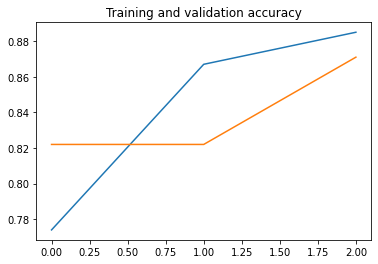

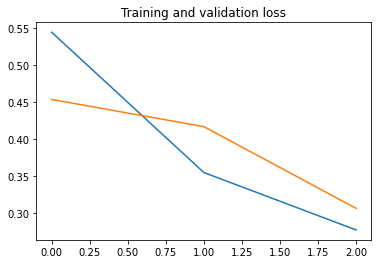

In [20]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [21]:
Y_pred = full_model.predict(validation_generator) 

In [22]:
# Ejemplo de pronóstico y su clase real.
print('Pronóstico:',Y_pred[0], ', y clase original: ',validation_generator.labels[0])

Pronóstico: [9.867731e-08 9.999999e-01] , y clase original:  0


ModuleNotFoundError: No module named 'google.colab'

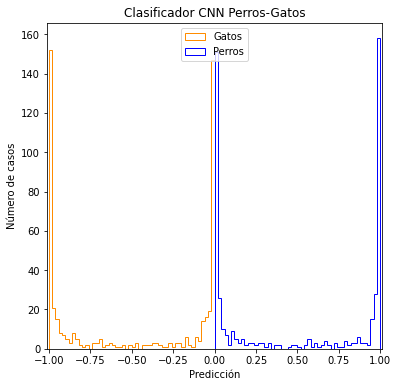

In [23]:
# Visualización de los pronósticos.
plt.figure(1,figsize=(6,6)) 
plt.style.use('seaborn-deep') 
plt.hist(-Y_pred[:500,0],50,histtype='step',color='darkorange', label= "Gatos")
plt.hist(Y_pred[500:,1],50,histtype='step',color='blue', label= "Perros")
plt.ylabel('Número de casos')
plt.xlabel('Predicción')
plt.title("Clasificador CNN Perros-Gatos")
plt.xlim(-1.01,1.01)
plt.legend( loc='upper center')

from google.colab import files
plt.savefig('ClasificadorCNNVGG16PerrosGatos.eps')
files.download('ClasificadorCNNVGG16PerrosGatos.eps') # Descomentar para descargar localmente

## Propuestas adicionales.

*   Si se compara con nuestra anterior propuesta de clasificador ¿Mejora la clasificación de perros y gatos con el uso de transferencia de aprendizaje a partir de una red VGG16?
*   Probar a mejorar la clasificación con otras redes preentrenadas:
https://www.tensorflow.org/api_docs/python/tf/keras/applications


